Using device: cuda
Using downloaded and verified file: ./data/oxford_pets/images.tar.gz
Extracting ./data/oxford_pets/images.tar.gz to ./data/oxford_pets/
Using downloaded and verified file: ./data/oxford_pets/annotations.tar.gz
Extracting ./data/oxford_pets/annotations.tar.gz to ./data/oxford_pets/
Dataset loaded, sample batch shape: torch.Size([4, 3, 256, 256])

Displaying some random raw samples from the dataset before training:


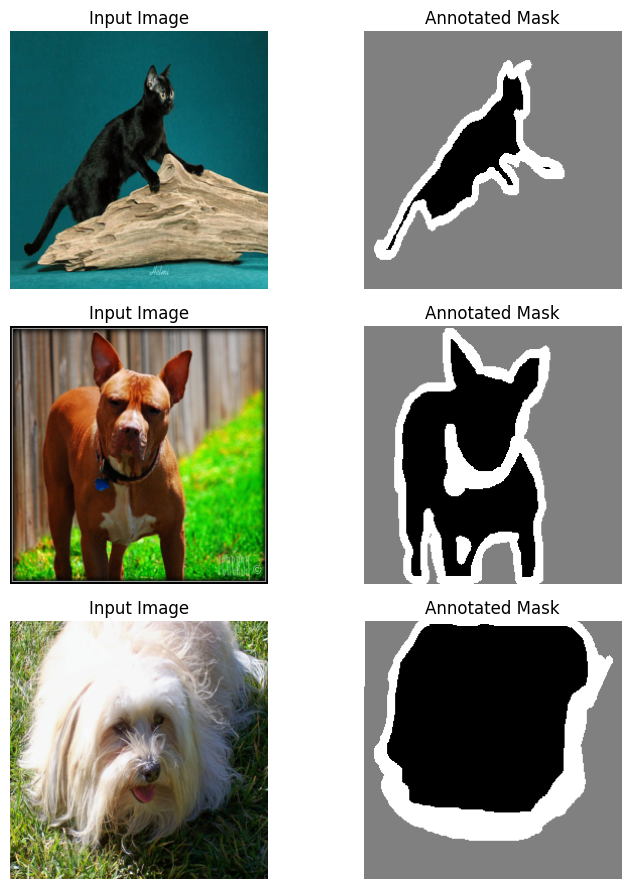

Model params: 25,867,075

Starting Final Demo Run: 3-Fold CV for 5 Epochs Each


========== Fold 1/3 ==========
Epoch 1/5 | Train Loss: 0.3220 | Val Loss: 0.2454 | IoU: 0.7541 | Dice: 0.8478
Epoch 2/5 | Train Loss: 0.2376 | Val Loss: 0.2650 | IoU: 0.7225 | Dice: 0.8214
Epoch 3/5 | Train Loss: 0.2142 | Val Loss: 0.2284 | IoU: 0.7631 | Dice: 0.8531
Epoch 4/5 | Train Loss: 0.1911 | Val Loss: 0.2177 | IoU: 0.7724 | Dice: 0.8606
Epoch 5/5 | Train Loss: 0.1772 | Val Loss: 0.2437 | IoU: 0.7581 | Dice: 0.8501

========== Fold 2/3 ==========
Epoch 1/5 | Train Loss: 0.3246 | Val Loss: 0.2397 | IoU: 0.7443 | Dice: 0.8376
Epoch 2/5 | Train Loss: 0.2376 | Val Loss: 0.2399 | IoU: 0.7633 | Dice: 0.8544
Epoch 3/5 | Train Loss: 0.2114 | Val Loss: 0.2292 | IoU: 0.7532 | Dice: 0.8449
Epoch 4/5 | Train Loss: 0.1959 | Val Loss: 0.2277 | IoU: 0.7759 | Dice: 0.8635
Epoch 5/5 | Train Loss: 0.1839 | Val Loss: 0.2028 | IoU: 0.7787 | Dice: 0.8640

========== Fold 3/3 ==========
Epoch 1/5 | Train Loss: 0.3278 | V

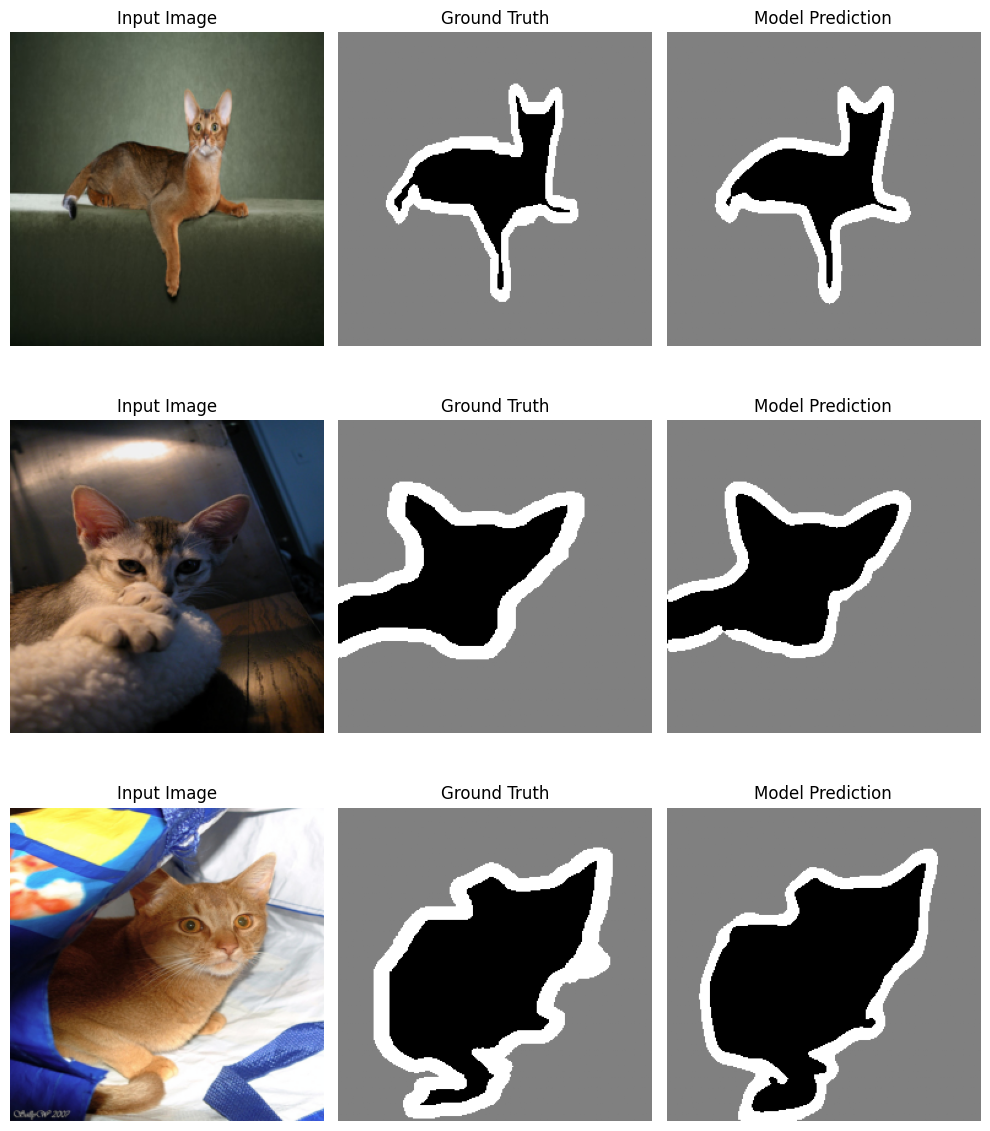

In [ ]:
# CS4287-Assign1-22352228-22340343.ipynb
# Names and IDs: Cormac Greaney - 22352228, Jan Lawinski - 22340343
# Code runs to completion: Yes
# Reused source: https://pytorch.org/vision/stable/models.html (for pretrained VGG16)
# Description: Image Segmentation on Oxford-IIIT Pet Dataset using VGG16-based U-Net


# ====================================================
# Here we have all of the imports used for our project
# ====================================================
import torch, torchvision
from torchvision.transforms import functional as TF
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.datasets.utils import download_and_extract_archive
from PIL import Image
import numpy as np, os, matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import random
import copy


# =====================================================================
# Here we check for a GPU so that we can drastically reduce the runtime 
# but will revert to the cpu if its run on a machine without a GPU
# =====================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# ==============================================================
# Here we download the Oxford-IIIT Pet datasets images and masks
# ==============================================================
root = "./data/oxford_pets/"
download_and_extract_archive(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz",
    download_root=root, extract_root=root)
download_and_extract_archive(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz",
    download_root=root, extract_root=root)


# =======================================================================
# Here we create our custom dataset class for the Oxford-IIIT Pet Dataset
# =======================================================================
class OxfordPetSegmentation(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, "trimaps", img_name.replace(".jpg", ".png"))

        # === Here we load the image and mask ===
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # === Here we resize the image and mask === 
        image = TF.resize(image, (256, 256), interpolation=Image.BILINEAR)
        mask = TF.resize(mask, (256, 256), interpolation=Image.NEAREST)

        # === Here we convert image to tensor and normalize the channels the match our pretrained VGG16 ===
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.485, 0.456, 0.406],
                                   [0.229, 0.224, 0.225])
        
        # === Here we convert mask to a NumPy array ===
        mask = np.array(mask)

        # === Here we adjust the mask labels to be 0,1,2 ===
        mask = np.clip(mask, 1, 3) - 1

        # === Here we convert to a long tensor ===
        mask = torch.from_numpy(mask).long()

        # === Here we return a tuple for training ===
        return image, mask


# === Transforms - not using atm ===
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


# ===============================
# Here we instantiate our dataset
# ===============================
dataset = OxfordPetSegmentation(
    img_dir=os.path.join(root, "images"),
    mask_dir=os.path.join(root, "annotations"),
    transform=transform
)


# ===================================================================
# Here we create our dataloader and wrap our dataset
# we will use a batch size of 4 for training with shuffling turned on
# ===================================================================
loader = DataLoader(dataset, batch_size=4, shuffle=True)


# ==============================================================
# Here we pull a sample batch to verify everything is working
# we print the shape of the batch as a sanity check
# ==============================================================
print("Dataset loaded, sample batch shape:", next(iter(loader))[0].shape)


# ===========================================================================
# Here we show some random samples to visualise our dataset (before training)
# ===========================================================================

# === Here we create a figure and randomly pick num_samples indices ===
def show_raw_samples(dataset, num_samples=3):
    plt.figure(figsize=(8, num_samples * 3))
    indices = random.sample(range(len(dataset)), num_samples)

    # === Here we pull single samples and plot them ===
    for i, idx in enumerate(indices):
        img, mask = dataset[idx]

        # === Here we undo the ImageNet normalisation ===
        img_np = img.permute(1, 2, 0).numpy()
        img_np = np.clip((img_np * np.array([0.229, 0.224, 0.225]) + 
                          np.array([0.485, 0.456, 0.406])), 0, 1)

        # === Here we convert mask to numpy for plotting ===
        mask_np = mask.numpy()

        # === Here we plot the image and mask side by side ===
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(img_np)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(num_samples, 2, i * 2 + 2)
        plt.imshow(mask_np, cmap="gray")
        plt.title("Annotated Mask")
        plt.axis("off")

    # === Here we adjust our layout and then show the plot ===
    plt.tight_layout()
    plt.show()


# ==================================================
# Here we call our function to show some raw samples
# ==================================================
print("\nDisplaying some random raw samples from the dataset before training:")
show_raw_samples(dataset, num_samples=3)


# ==========================================
# Here we define our VGG16-based U-Net model
# ==========================================
class UNetVGG16(nn.Module):

    # === Here we define the cunstructor with 3 classes, background, pet, border ===
    def __init__(self, n_classes=3):
        super().__init__()

        # === Here we load the pretrained VGG16 model ===
        vgg = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1)

        # === Here we extract the features layers into a python list so it can be sliced ===
        features = list(vgg.features.children())

        # === Here we create slices of VGG16 for the encoder path ===
        self.enc1 = nn.Sequential(*features[:6])    # 64 filters
        self.enc2 = nn.Sequential(*features[6:13])  # 128 filters
        self.enc3 = nn.Sequential(*features[13:23]) # 256 filters
        self.enc4 = nn.Sequential(*features[23:33]) # 512 filters
        self.center = nn.Sequential(*features[33:43]) # 512 bottleneck

        # === Here we define the decoder path with upsampling and conv layers ===
        self.up4 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.dec4 = nn.Sequential(
            nn.Conv2d(512 + 512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.final = nn.Conv2d(64, n_classes, kernel_size=1)

    # === Here we define our forward pass ===
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        c = self.center(e4)

        d4 = self.up4(c)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.final(d1)


# ==========================================================================
# Here we instantiate our model and move it to the device we checked earlier
# ==========================================================================
model = UNetVGG16().to(device)


# ===============================================================================
# Here we print the number of trainable parameters in the model as a sanity check
# ===============================================================================
print(f"Model params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


# ================================================================================
# Here we define our loss function - CrossEntropyLoss for multi-class segmentation
# ================================================================================
criterion = nn.CrossEntropyLoss()


# ==========================================================================================
# Here we use the more modern AdamW optimizer with decoupled weight decay for regularization
# We set a learning rate of 3e-4 and weight decay of 1e-4
# ==========================================================================================
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)


# ==============================================================================================
# Here we define a learning rate scheduler to reduce our learning rate
# it will be halved when a monitored metric stops showing improvement within our patience period
# ==============================================================================================
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)


# ===================================================
# Here we define a simple training loop for one epoch
# ===================================================
def train_one_epoch(model, loader, criterion, optimizer):

    # === Here we set the model to training mode ===
    model.train()

    # === Here we initialize total loss for the epoch ===
    total_loss = 0

    # === Here we loop over the data loader ===
    for imgs, masks in loader:

        # === Here we move the images and masks to the device ===
        imgs, masks = imgs.to(device), masks.to(device)

        # === Here we zero the gradients, perform a forward pass, compute the loss, perform a backward pass, and update weights ===
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        # === Here we add the loss to the total loss ===
        total_loss += loss.item()

    # === Here we return the mean loss for the epoch ===    
    return total_loss / len(loader)


# ===========================================================================
# Here we define our helper functions for evaluating the segmentation quality
# ===========================================================================
def compute_iou(preds, labels, num_classes=3):

    # === Here we compute the mean Intersection over Union (mIoU) across classes ===
    ious = []
    preds = torch.argmax(preds, dim=1)  
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        intersection = (pred_inds & target_inds).float().sum()
        union = (pred_inds | target_inds).float().sum()
        if union == 0:
            ious.append(torch.tensor(float('nan')))  
        else:
            ious.append(intersection / union)
    return torch.tensor(ious).nanmean().item()


def compute_dice(preds, labels, num_classes=3):
    # === Here we compute mean Dice coefficient across classes ===
    dice_scores = []
    preds = torch.argmax(preds, dim=1)
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (labels == cls)
        intersection = (pred_inds & target_inds).float().sum()
        dice = (2. * intersection) / (pred_inds.float().sum() + target_inds.float().sum() + 1e-8)
        dice_scores.append(dice)
    return torch.tensor(dice_scores).nanmean().item()


# ===============================================================
# Here we define our validation loop to measure model performance
# ===============================================================
def validate(model, loader, criterion):
    # === Here we set to evaluation mode ===
    model.eval() 
    total_loss = 0
    total_iou = 0
    total_dice = 0
    count = 0

    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            total_iou += compute_iou(outputs, masks)
            total_dice += compute_dice(outputs, masks)
            count += 1

    # === Here we compute average metrics ===
    avg_loss = total_loss / count
    avg_iou = total_iou / count
    avg_dice = total_dice / count

    return avg_loss, avg_iou, avg_dice


# ======================================================================
# Here we implement K-Fold Cross Validation to better evaluate our model
# ======================================================================

# === Here we create our K-Fold splitter and the structure to hold results ===
def run_kfold(model_class, dataset, k=3, epochs=1):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    best_iou_overall = -1.0
    best_state_overall = None

    # === Here we loop over each fold ===
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"\n========== Fold {fold + 1}/{k} ==========")

        # === Here we build per-fold subsets and dataloaders ===
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=4, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=4, shuffle=False)

        # === Here we instantiate a new model, optimizer, scheduler, and criterion for this fold ===
        model = model_class().to(device)
        optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
        criterion = nn.CrossEntropyLoss()

        # === Here we track the best IoU and model state for this fold ===
        best_iou_this_fold = -1.0
        best_state_this_fold = None

        # === Here we run the training and validation for the specified number of epochs ===
        for epoch in range(epochs):
            train_loss = train_one_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_iou, val_dice = validate(model, val_loader, criterion)
            scheduler.step(val_iou)

            # === Here we print the epoch results ===
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"IoU: {val_iou:.4f} | Dice: {val_dice:.4f}")

            # === Here we save the best weights for this fold by IoU ===
            if val_iou > best_iou_this_fold:
                best_iou_this_fold = val_iou
                best_state_this_fold = copy.deepcopy(model.state_dict())
        
        # === Here we record the results ===
        fold_results.append({
            "fold": fold + 1,
            "val_loss": val_loss,
            "val_iou": best_iou_this_fold,
            "val_dice": val_dice
        })

        # === Here we track the global best wieghts across all folds ===
        if best_iou_this_fold > best_iou_overall:
            best_iou_overall = best_iou_this_fold
            best_state_overall = copy.deepcopy(best_state_this_fold)

    # === Here we compute the mean and standard deviation of metrics across folds ===
    avg_iou = np.mean([f["val_iou"] for f in fold_results])
    std_iou = np.std([f["val_iou"] for f in fold_results])
    avg_dice = np.mean([f["val_dice"] for f in fold_results])
    std_dice = np.std([f["val_dice"] for f in fold_results])

    # === Here we print our report ===
    print("\n========== K-Fold Results ==========")
    print(f"Mean IoU:  {avg_iou:.4f} ± {std_iou:.4f}")
    print(f"Mean Dice: {avg_dice:.4f} ± {std_dice:.4f}")

    # === Here we rebuild a fresh model and load the best overall weights ===
    best_model = model_class().to(device)
    if best_state_overall is not None:
        best_model.load_state_dict(best_state_overall)
        best_model.eval()

    # === Here we return the fold results and the best model ===
    return fold_results, best_model


# ====================================================================
# Here we define a simple experiment runner for hyperparameter testing
# ====================================================================
def run_experiment(lr=3e-4, weight_decay=1e-4, dropout=False, augment=False, epochs=1):

    # === Here we run a single training + validation experiment with custom hyperparameters ===
    # === Used to measure how changes in LR, dropout, or augmentation affect performance ===
    print(f"\nRunning experiment | lr={lr} | wd={weight_decay} | dropout={dropout} | augment={augment}")

    # === Here we have optional data augmentation ===
    if augment:
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])

    # === Here we rebuild the dataset with/without augmentation ===
    dataset_exp = OxfordPetSegmentation(
        img_dir=os.path.join(root, "images"),
        mask_dir=os.path.join(root, "annotations"),
        transform=transform
    )

    # === Here we use a small subset for faster experiments ===
    subset_indices = range(500)
    dataset_exp = torch.utils.data.Subset(dataset_exp, subset_indices)
    loader = DataLoader(dataset_exp, batch_size=4, shuffle=True)

    # === Here we define the model ===
    model = UNetVGG16().to(device)

    # === Here we add the dropout if its enabled ===
    if dropout:
        def add_dropout(m):
            if isinstance(m, nn.ReLU):
                return nn.Sequential(m, nn.Dropout(0.3))
            return m
        model.apply(add_dropout)

    # === Here we have our optimizer, loss, and scheduler ===
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
    criterion = nn.CrossEntropyLoss()

    # === Here we run the training and validation on the same loader for speed ===
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, loader, criterion, optimizer)
        val_loss, val_iou, val_dice = validate(model, loader, criterion)
        scheduler.step(val_iou)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"IoU: {val_iou:.4f} | Dice: {val_dice:.4f}")

    # === Here we return the results ===
    return {"lr": lr, "wd": weight_decay, "dropout": dropout, "augment": augment,
            "val_iou": val_iou, "val_dice": val_dice}


# ===============================================================
# Here we run a demo of our one epoch function and store the loss
# ===============================================================
# (commented out) demo_loss = train_one_epoch(model, loader, criterion, optimizer)


# ================================================================
# Here we run a validation demo to check IoU and Dice calculations
# ================================================================
# (commented out) val_loss, val_iou, val_dice = validate(model, loader, criterion)
# (commented out) print(f"Validation → Loss: {val_loss:.4f}, mIoU: {val_iou:.4f}, Dice: {val_dice:.4f}")


# ============================================================
# For quick testing we can use a smaller subset of the dataset
# ============================================================
subset_indices = range(500)
small_dataset = torch.utils.data.Subset(dataset, subset_indices)


# =========================================================
# Here we run kfold on a smaller dataset for faster testing
# =========================================================
# (commented out) kfold_results = run_kfold(UNetVGG16, small_dataset, k=3, epochs=1)

# ============================================================================
# Here we run a few hyperparameter variation and data augmentation experiments
# ============================================================================
# (commented out) experiments = [
# (commented out)   {"lr": 1e-3, "weight_decay": 1e-4, "dropout": False, "augment": False},
# (commented out)   {"lr": 3e-4, "weight_decay": 1e-4, "dropout": True,  "augment": False},
# (commented out)   {"lr": 3e-4, "weight_decay": 1e-4, "dropout": False, "augment": True},
# (commented out) ]

# (commented out) results = []

# === Here we loop over each experiment and store the results ===
# (commented out) for exp in experiments:
# (commented out)    result = run_experiment(**exp, epochs=1)
# (commented out)    results.append(result)

# === Here we print a summary table ===
# (commented out) print("\n========== Hyperparameter Experiment Results ==========")
# (commented out) for r in results:
# (commented out)    print(f"LR={r['lr']:.0e}, Dropout={r['dropout']}, Augment={r['augment']} → "
# (commented out)          f"IoU={r['val_iou']:.4f}, Dice={r['val_dice']:.4f}")


# ========================================================
# Here we have our function to visualize model predictions
# ========================================================
def visualize_predictions(model, dataset, num_samples=3):
    # === Here we set the model to evaluation mode ===
    model.eval()
    plt.figure(figsize=(10, num_samples * 4))

    # === Here we grab random samples from the dataset ===
    for i in range(num_samples):
        img, mask = dataset[i]
        img = img.unsqueeze(0).to(device)

        # === Here we get the model prediction ===
        with torch.no_grad():
            output = model(img)
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        # === Here we undo the ImageNet normalisation for visualization ===
        img_np = img.squeeze().permute(1, 2, 0).cpu().numpy()
        img_np = np.clip((img_np * np.array([0.229, 0.224, 0.225]) + 
                          np.array([0.485, 0.456, 0.406])), 0, 1)

        # === Here we convert the masks to numpy for plotting ===
        mask_np = mask.numpy()

        # === Here we plot the input image, ground truth mask, and our models prediction ===
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img_np)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(pred, cmap='gray')
        plt.title("Model Prediction")
        plt.axis("off")

    # === Here we adjust the layout and show the plot ===
    plt.tight_layout()
    plt.show()


# =============================================================
# Here we create a small subset for quick visualization testing
# =============================================================

# === Here we create a small subset and dataloader for visualization ===
subset_indices = range(200)
viz_dataset = torch.utils.data.Subset(dataset, subset_indices)
viz_loader = DataLoader(viz_dataset, batch_size=4, shuffle=True)

# === Here we instantiate a fresh model, optimizer, and criterion ===
model = UNetVGG16().to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# === Here we run a quick training epoch for visualization testing ===
# (commented out) train_one_epoch(model, viz_loader, criterion, optimizer)


# ==================================
# Visualize a few random predictions
# ==================================
# (commented out) visualize_predictions(model, viz_dataset, num_samples=3)


# =======================================
# Here we run our 3-Fold Cross Validation 
# =======================================
# (commented out) kfold_results = run_kfold(UNetVGG16, dataset, k=3, epochs=1)


# ==========================================================
# Here we print the one epoch demos loss to 4 decimal places
# ==========================================================
# (commented out) print(f"One-epoch demo loss: {demo_loss:.4f}")


# =====================================================================================
# Here is our FINAL DEMO RUN — Full Dataset, 3-Fold Cross Validation, 5 Epochs per Fold
# =====================================================================================
# This is our main final experiment: it uses the complete dataset and performs
# 3-Fold Cross Validation over 5 epochs per fold. It prints some sample images 
# and their annotated masks at the start. It prints IoU/Dice metrics and
# visualises some examples of our models predictions at the end
# =====================================================================================

# === Here we tune the k folds and epochs for the final run ===
k_folds = 3
num_epochs = 5

# === Here we display some raw samples before training ===
print(f"\nStarting Final Demo Run: {k_folds}-Fold CV for {num_epochs} Epochs Each\n")

# === Here we run the final demo ===
final_results, best_model = run_kfold(UNetVGG16, dataset, k=k_folds, epochs=num_epochs)

print("\nFinal Demo Complete!")

# === Here we visualise predictions from the best trained model ===
subset_indices = range(10)
viz_dataset = torch.utils.data.Subset(dataset, subset_indices)
visualize_predictions(best_model, viz_dataset, num_samples=3)

